# CrowdTruth for Sparse Multiple Choice Tasks: Event Extraction


In [1]:
import pandas as pd
file_name = "all_crowd_event"
test_data = pd.read_csv("../../data/main_crowd_data/raw_data/" + file_name + ".csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,...,doc_id,events,lemmas,number_possible_pgsm_events,pos_tags,sentence,sentence_id,tokens,all_events,worker_events
0,2079348225,1/8/2019 21:55:03,4406451754,1/8/2019 21:54:33,False,neodev,1,e41850c29bb7b5ccb792c36eb94e6702,USA,MN,...,NYT20000403.0463,5,24,9,24,Legal experts and federal officials maintain t...,22,24,"[""maintain__36__44"",""heard__118__123"",""appeal_...","[""maintain__36__44"",""heard__118__123"",""appeal_..."
1,2079348225,1/8/2019 22:38:22,4406662068,1/8/2019 22:37:24,False,elite,1,fd4c8cbeb7fe01499480d1344c50df5f,CAN,BC,...,NYT20000403.0463,5,24,9,24,Legal experts and federal officials maintain t...,22,24,"[""maintain__36__44"",""heard__118__123"",""appeal_...","[""maintain__36__44"",""heard__118__123"",""appeal_..."
2,2079348225,1/8/2019 22:50:01,4406688668,1/8/2019 22:49:09,False,prodege,1,e1348a79a458a304fb5c1eaa37e3d459,CAN,ON,...,NYT20000403.0463,5,24,9,24,Legal experts and federal officials maintain t...,22,24,"[""maintain__36__44"",""heard__118__123"",""appeal_...","[""maintain__36__44"",""heard__118__123"",""appeal_..."
3,2079348225,1/8/2019 22:52:33,4406694302,1/8/2019 22:52:18,False,instagc,1,d07d4bb72cf5c30527d765473f962167,USA,TX,...,NYT20000403.0463,5,24,9,24,Legal experts and federal officials maintain t...,22,24,"[""no_event""]","[""no_event""]"
4,2079348225,1/8/2019 23:29:36,4406769854,1/8/2019 23:28:54,False,elite,1,e4bc3855f033f3d16c192dcc9fbb25f6,GBR,E4,...,NYT20000403.0463,5,24,9,24,Legal experts and federal officials maintain t...,22,24,"[""maintain__36__44"",""appeal__108__114"",""sent__...","[""maintain__36__44"",""appeal__108__114"",""sent__..."


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Relation Extraction task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of all relations that were given as input to the crowd in at least one sentence
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
import logging
import warnings; warnings.simplefilter('ignore')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


class TestConfig(DefaultConfig):
    inputColumns = ["doc_id", "total_events_gold", "sentence", "lowercase_sentence", "sentence_id", "all_possible_pgsm_events", "worker_events"]
    outputColumns = ["all_events"]
    
    annotation_separator = ","
        
    # processing of a closed task
    open_ended_task = True
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [4]:
data_open, config = crowdtruth.load(
    file = "../../data/main_crowd_data/raw_data/" + file_name + ".csv",
    config = TestConfig()
)

data_open['judgments'].head()

INFO:root:Config loaded
INFO:root:Values not stored as dictionary


,output.all_events,output.all_events.count,output.all_events.unique,unit,worker,started,submitted,duration,job
judgment,,,,,,,,,
4406451754,"{'maintain__36__44': 1, 'heard__118__123': 1, ...",6,6,2079348225,e41850c29bb7b5ccb792c36eb94e6702,2019-01-08 21:54:33,2019-01-08 21:55:03,30,../../data/main_crowd_data/raw_data/all_crowd_...
4406662068,"{'maintain__36__44': 1, 'heard__118__123': 1, ...",9,9,2079348225,fd4c8cbeb7fe01499480d1344c50df5f,2019-01-08 22:37:24,2019-01-08 22:38:22,58,../../data/main_crowd_data/raw_data/all_crowd_...
4406688668,"{'maintain__36__44': 1, 'heard__118__123': 1, ...",5,5,2079348225,e1348a79a458a304fb5c1eaa37e3d459,2019-01-08 22:49:09,2019-01-08 22:50:01,52,../../data/main_crowd_data/raw_data/all_crowd_...
4406694302,{'no_event': 1},1,1,2079348225,d07d4bb72cf5c30527d765473f962167,2019-01-08 22:52:18,2019-01-08 22:52:33,15,../../data/main_crowd_data/raw_data/all_crowd_...
4406769854,"{'maintain__36__44': 1, 'appeal__108__114': 1,...",5,5,2079348225,e4bc3855f033f3d16c192dcc9fbb25f6,2019-01-08 23:28:54,2019-01-08 23:29:36,42,../../data/main_crowd_data/raw_data/all_crowd_...


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [5]:
results_open = crowdtruth.run(data_open, config)

INFO:root:1 iterations; max d= 0.9994209960794347 ; wqs d= 0.5942385150116546; uqs d= 0.47264463503414805; aqs d= 0.0
INFO:root:2 iterations; max d= 0.26606138724515316 ; wqs d= 0.05477524518163954; uqs d= 0.08706217528417261; aqs d= 0.0
INFO:root:3 iterations; max d= 0.016554420736566933 ; wqs d= 0.003321588097871867; uqs d= 0.0016262680937486876; aqs d= 0.0
INFO:root:4 iterations; max d= 0.009111166209350041 ; wqs d= 0.0008046528637709756; uqs d= 0.0020163793993467536; aqs d= 0.0
INFO:root:5 iterations; max d= 0.001050031259381301 ; wqs d= 0.0001217101917497509; uqs d= 0.000138067294555721; aqs d= 0.0
INFO:root:6 iterations; max d= 0.0004079069707931815 ; wqs d= 2.9616980597634114e-05; uqs d= 8.085925521836281e-05; aqs d= 0.0


`results` is a dict object that contains the quality metrics for sentences, events and crowd workers.

The **sentence metrics** are stored in `results["units"]`:

In [6]:
results_open["units"].head()

,duration,input.all_possible_pgsm_events,input.doc_id,input.sentence,input.sentence_id,input.worker_events,job,output.all_events,output.all_events.annotations,output.all_events.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,
2075970126,52.933333,"covering__82__90###Met__53__56###,__46__47###O...",bbc_20130322_1600,There are 12 flood warnings in the South West ...,4,"[""covering__82__90"",""flood__13__18"",""warnings_...",../../data/main_crowd_data/raw_data/all_crowd_...,"{'covering__82__90': 10, 'flood__13__18': 10, ...",58,13,15,0.535636,"{'covering__82__90': 0.737068216684402, 'flood...",0.506402,"{'covering__82__90': 0.6666666666666666, 'floo..."
2075970127,72.133333,expects__3__10###take__45__49###complete__78__...,bbc_20130322_332,BP expects the share buyback programme could t...,6,"[""expects__3__10"",""take__45__49"",""complete__78...",../../data/main_crowd_data/raw_data/all_crowd_...,"{'expects__3__10': 11, 'take__45__49': 12, 'co...",48,10,15,0.684564,"{'expects__3__10': 0.7987508767789508, 'take__...",0.618375,"{'expects__3__10': 0.7333333333333333, 'take__..."
2075970128,35.133333,helped__51__57###summit__103__109###was__25__2...,bbc_20130322_1150,New Zealand-born Mr Lowe was part of the team ...,2,"[""helped__51__57""]",../../data/main_crowd_data/raw_data/all_crowd_...,"{'helped__51__57': 14, 'was__25__28': 4, 'summ...",34,6,15,0.665710,"{'helped__51__57': 0.9579307113118284, 'was__2...",0.647597,"{'helped__51__57': 0.9333333333333333, 'was__2..."
2075970129,27.600000,conquered__50__59###died__80__84###surviving__...,bbc_20130322_1150,The last surviving member of the team which fi...,0,"[""conquered__50__59"",""died__80__84""]",../../data/main_crowd_data/raw_data/all_crowd_...,"{'conquered__50__59': 15, 'died__80__84': 14, ...",57,11,15,0.686946,"{'conquered__50__59': 1.0, 'died__80__84': 0.9...",0.673428,"{'conquered__50__59': 1.0, 'died__80__84': 0.9..."
2075970130,41.466667,took__13__17###expedition__46__56###made__78__...,bbc_20130322_1150,Mr Lowe also took part in the trans-Antarctic ...,4,"[""expedition__46__56"",""made__78__82"",""crossing...",../../data/main_crowd_data/raw_data/all_crowd_...,"{'expedition__46__56': 12, 'made__78__82': 10,...",78,23,15,0.572890,"{'expedition__46__56': 0.784327603143627, 'mad...",0.540694,"{'expedition__46__56': 0.8, 'made__78__82': 0...."


The `uqs` column in `results["units"]` contains the **sentence quality scores**, capturing the overall workers agreement over each sentence. Here we plot its histogram:

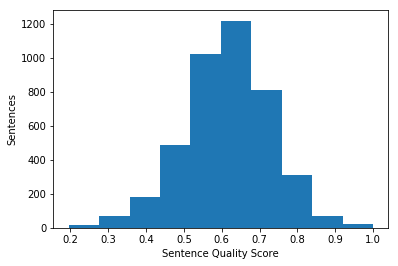

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results_open["units"]["uqs"])
plt.xlabel("Sentence Quality Score")
plt.ylabel("Sentences")


The `unit_annotation_score` column in `results["units"]` contains the **sentence-relation scores**, capturing the likelihood that a relation is expressed in a sentence. For each sentence, we store a dictionary mapping each relation to its sentence-relation score.

In [8]:
results_open["units"]["unit_annotation_score"].head(10)

unit
2075970126    {'covering__82__90': 0.737068216684402, 'flood...
2075970127    {'expects__3__10': 0.7987508767789508, 'take__...
2075970128    {'helped__51__57': 0.9579307113118284, 'was__2...
2075970129    {'conquered__50__59': 1.0, 'died__80__84': 0.9...
2075970130    {'expedition__46__56': 0.784327603143627, 'mad...
2075970131    {'died__70__74': 0.9169407352415849, 'climbing...
2075970132    {'said__38__42': 0.7701809807122708, 'estimate...
2075970133    {'invested__3__11': 1.0, 'it invested in tnk-b...
2075970134    {'invested__14__22': 0.9169407352415849, 'said...
2075970135    {'met__117__120': 0.7363919041433489, 'called_...
Name: unit_annotation_score, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [9]:
results_open["workers"].head()

,unit,judgment,job,duration,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
07fe811ad57531a29d0ce82daedb4ad7,628,628,1,202.695860,0.297602,0.496637,0.599234,0.248704,0.430335,0.577931
099803428607e4a8b1b419145d53ad5c,1323,1323,1,17.320484,0.552425,0.686179,0.805075,0.485170,0.615437,0.788334
0a3302e56f7d6a1edc99700f53076e2d,253,253,1,40.505929,0.587981,0.689083,0.853281,0.509043,0.611994,0.831779
0b095ebfd3609700ad47be07a8a0a9b1,1365,1365,1,47.573626,0.653077,0.731913,0.892287,0.572374,0.655181,0.873612
0d9bdc31b5837ca4dbf0a99ba7add9b5,11,11,1,99.000000,0.539457,0.660489,0.816753,0.491505,0.615679,0.798313


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

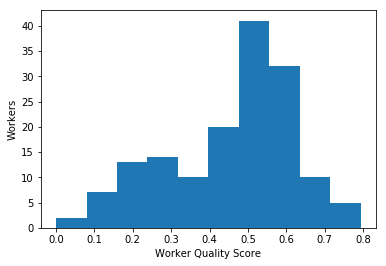

In [10]:
plt.hist(results_open["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")

In [11]:
print(results_open["units"].iloc[0])

duration                                                                          52.9333
input.all_possible_pgsm_events          covering__82__90###Met__53__56###,__46__47###O...
input.doc_id                                                            bbc_20130322_1600
input.sentence                          There are 12 flood warnings in the South West ...
input.sentence_id                                                                       4
input.worker_events                     ["covering__82__90","flood__13__18","warnings_...
job                                     ../../data/main_crowd_data/raw_data/all_crowd_...
output.all_events                       {'covering__82__90': 10, 'flood__13__18': 10, ...
output.all_events.annotations                                                          58
output.all_events.unique_annotations                                                   13
worker                                                                                 15
uqs       

## Save crowd results in a csv file

In [12]:
rows = []
header = list(results_open["units"])
header.extend(["validated_event", "no_of_annotations", "validated_event_final_score", "validated_event_initial_score"])

rows.append(header)

for i in range(len(results_open["units"].index)):
    keys = []

    all_event_runs = results_open["units"]["input.all_possible_pgsm_events"].iloc[i].lower().split("###")
    keys.extend(all_event_runs)
    keys.append("no_event")
    
    for crowd_event in results_open["units"]["output.all_events"].iloc[i]:
        crowd_event = crowd_event.replace("###", ",")
        crowd_event = crowd_event.replace("---", "''")
        crowd_event = crowd_event.replace("|||", "'")
        if crowd_event not in keys:
            keys.append(crowd_event)
    
    for j in range(len(keys)):
        row = list(results_open["units"].iloc[i])
        row.append(keys[j])
        row.append(results_open["units"]["output.all_events"].iloc[i][keys[j].lower()])
        row.append(results_open["units"]["unit_annotation_score"].iloc[i][keys[j].lower()])
        row.append(results_open["units"]["unit_annotation_score_initial"].iloc[i][keys[j].lower()])
    
        rows.append(row)
        
        
import csv

with open('../../data/main_crowd_data/results/' + file_name + '_units_open.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)

## Comparison with Expert Annotations

In [14]:
# expert annotations in TempEval-3 Platinum dataset
import numpy as np
           
expert_data = pd.read_csv("../../data/TempEval3-data/TE3-Gold_events.csv")
expert_platinum_data = pd.read_csv("../../data/TempEval3-data/TE3-Platinum_events.csv")
crowd_data = pd.read_csv("../../data/main_crowd_data/results/" + file_name + "_units_open.csv")
crowd_data["Experts"] = 0

for i in range(len(crowd_data.index)):
    #print(i)
    subset = expert_data[(expert_data["Doc Id"].str.lower() == crowd_data["input.doc_id"].iloc[i].lower()) & (expert_data["Sentence Id"] == crowd_data["input.sentence_id"].iloc[i])]# & (str(str(expert_data["Lowercase Token"]) + "__" + str(expert_data["Start Offset"]) + "__" + str(expert_data["End Offset"])) == str(crowd_data["validated_event"].iloc[i]))]
    found = False
    for j in range(len(subset.index)):
        if str(str(subset["Lowercase Token"].iloc[j]) + "__" + str(subset["Start Offset"].iloc[j]) + "__" + str(subset["End Offset"].iloc[j])) == crowd_data["validated_event"].iloc[i]:
            found = True
    if found == True:
        crowd_data["Experts"].iloc[i] = 1
    else:
        subset = expert_platinum_data[(expert_platinum_data["Doc Id"].str.lower() == crowd_data["input.doc_id"].iloc[i].lower()) & (expert_platinum_data["Sentence Id"] == crowd_data["input.sentence_id"].iloc[i])]# & (str(str(expert_data["Lowercase Token"]) + "__" + str(expert_data["Start Offset"]) + "__" + str(expert_data["End Offset"])) == str(crowd_data["validated_event"].iloc[i]))]
        found = False
        for j in range(len(subset.index)):
            if str(str(subset["Lowercase Token"].iloc[j]) + "__" + str(subset["Start Offset"].iloc[j]) + "__" + str(subset["End Offset"].iloc[j])) == crowd_data["validated_event"].iloc[i]:
                found = True
        if found == True:
            crowd_data["Experts"].iloc[i] = 1
        else:
            crowd_data["Experts"].iloc[i] = 0
crowd_data.to_csv("../../data/main_crowd_data/results/" + file_name + "_units_open.csv", index=False)    


In [15]:
import eval_crowd_results as eval_script

crowd = pd.read_csv('../../data/main_crowd_data/results/' + file_name + '_units_open.csv')
eval_file = eval_script.compute_crowd_performance(crowd, "validated_event_final_score")
     
with open('../../data/main_crowd_data/results/eval_' + file_name + '_units_open.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(eval_file)
    
eval_main = pd.read_csv("../../data/main_crowd_data/results/eval_" + file_name + "_units_open.csv")
eval_main

,Thresh,TP,TN,FP,FN,Precision,Recall,Accuracy,F1-score
0,0.05,11872,17685,25974,3,0.313692,0.999747,0.532233,0.477545
1,0.10,11858,24922,18737,17,0.387580,0.998568,0.662297,0.558418
2,0.15,11845,26969,16690,30,0.415104,0.997474,0.698923,0.586241
3,0.20,11802,29644,14015,73,0.457141,0.993853,0.746318,0.626234
4,0.25,11743,31638,12021,132,0.494151,0.988884,0.781161,0.658997
5,0.30,11677,33300,10359,198,0.529906,0.983326,0.809900,0.688685
6,0.35,11591,34962,8697,284,0.571323,0.976084,0.838279,0.720766
7,0.40,11474,36498,7161,401,0.615723,0.966232,0.863831,0.752147
8,0.45,11292,37800,5859,583,0.658387,0.950905,0.883999,0.778061
9,0.50,11024,38963,4696,851,0.701272,0.928337,0.900115,0.798985
